In [1]:
#select where to run this notebook---
binder_or_localpc=True #True: if you want to run the script using binder or in your local PC
google_colab=False #True: if you want to run the script in google colab

In [2]:
%%capture
#!pip freeze. #to list the packages installed in colab
#or install without checking above (!but do it just once)---
#select these versions to avoid compatibility issues in Colab
if google_colab:
    !pip install "numpy==1.24.4"
    !pip install "matplotlib==3.7.1" #Install matplotlib 3.7 or greater (known to have fix)
    !pip install "xarray==2023.1.0"
    !pip install tqdm

In [3]:
#open packages---
import numpy as np
import xarray as xr
from tqdm import tqdm
import os
import sys
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib as mpl
#for projections
from pyproj import Transformer 

In [4]:
#modify the local path in case you run this script in your computer---
if binder_or_localpc:
    dir_main="../"
if google_colab:
    #google colab path:
    mount_point='/content/gdrive/' #dir name for a temporal mount point (just for running this script)
    gdrive_path="MyDrive/colab_repos/" #the path in "my Google Drive" where you have cloned the repo
    dir_main=mount_point+gdrive_path
    #mount:
    from google.colab import drive
    drive.mount(mount_point)

In [5]:
#don't modify below paths---
#name of the repository:
if binder_or_localpc: 
    dir_repo=""
if google_colab:
    #name of directories from the cloned github repo:
    dir_repo="paper_Efficient_Deep_Learning_Surrogate_Method_For_Lagrangian_Transport/"
dir_data="data/"
dir_functions="functions/"
dir_figures="figures/"
dir_output="output/"
#name of files with data:
file_advection_dispersion_for_optimal_prediction="file_advection_dispersion_for_optimal_prediction.nc"
file_advection_dispersion_for_surrogate_prediction="file_advection_dispersion_for_surrogate_prediction.nc"
file_bathymetry="dws_bathymetry_200x200m.nc"
file_dws_particles_bound_400m=f"dws_particle_boundaries_400x400m.nc"
file_dws_bound="dws_boundaries_200x200m.nc" #only used for plotting

In [6]:
#import helper functions---
sys.path.append(dir_main+dir_repo+dir_functions)
from helpers_for_running_simplified_LPTM import xr_eig, xr_matmul, get_inoutp_dws, save_track_data
from helpers_for_plotting import get_statistics, save_statistics, get_bins, binning_particles, transform_coordinates, create_cmap

In [7]:
#create dir figures if it does not exists---
if not os.path.exists(dir_main+dir_repo+dir_figures):
    os.makedirs(dir_main+dir_repo+dir_figures)

In [8]:
#set global parameters for figures---
glob_font_size=11
params = {'legend.fontsize':glob_font_size-2,
          'axes.titlesize':glob_font_size,'axes.labelsize': glob_font_size, #size of titles, x-y labels 
          'xtick.labelsize':glob_font_size-1,'ytick.labelsize':glob_font_size-1, #size of xtick-labels, ytick-labels
          'xtick.major.size':2,'xtick.major.width':.8, #length and width of xticks marks
          'ytick.major.size':2,'ytick.major.width':.8,} #length and width of yticks marks
mpl.rcParams.update(params)

## 1) Compute the residual evolution of a patch for the Optimal and Surrogate prediction (windy period of Figure 5)

In [9]:
#Inputs----
#set tracking time:
tracking_time=14 #(integer) tracking time in tidal periods
tidal_period=44714 #(seconds) = (12.42h+2s)

#properties of the particle patch:
cpoint_lat=53.075; cpoint_lon=5.1 #central point of the patch within the DWS (latitude, longitude)
dxp=dyp=2 #(m) grid of particles within this patch: release one particle in the center of every dxp x dyp cell within the patch
l=0.8 #(km) length of the square that represents the patch

#define more inputs:
mean=0; std=1 #properties of the gaussian noise for Eq. (4) 
typevar='float32' 
dx_getm=200; dy_getm=200 #resolution of GETM-DWS simulation (m)

#names coast and islands:
names_bdr=["coast","texel","vlieland","terschelling","ameland","schiermonnikoog"]

In [10]:
#open data------

#open topography file
dsto=xr.open_dataset(dir_main+dir_repo+dir_data+file_bathymetry)

#open DWS particles boundaries for 400x400m domain
dsb_400m=xr.open_dataset(dir_main+dir_repo+dir_data+file_dws_particles_bound_400m) #open contour of land based on particles boundaries (the only difference with above is for the mainland)
bdr_dws_par_400m=dsb_400m.bdr_dws.values

#open a small set of advection and dispersion data for the optimal prediction
disCMdisp_optimal_prediction=xr.open_dataset(dir_main+dir_repo+dir_data+file_advection_dispersion_for_optimal_prediction)

#open a small set of advection and dispersion data for the surrogate prediction
disCMdisp_surrogate_prediction=xr.open_dataset(dir_main+dir_repo+dir_data+file_advection_dispersion_for_surrogate_prediction)

In [11]:
#select the first deployment date (this correspond to the windy case of Figure 5)----
it=0 #first deployment (with the provided dataset we can only select unitl the next deployment it=1 when tracking_time=14)
t_dep=[disCMdisp_optimal_prediction.time[it].values] 
t_dep

[numpy.datetime64('2015-11-27T21:37:54.000000000')]

In [12]:
#get a square particle patch around its central point defined by (lat,lon)---
def set_particles_around_point(lat,lon,dxp,dyp,l,xgrid,ygrid,dsto,bdr_dws,dx_getm,dy_getm,typevar):
    #
    xc,yc,h=dsto.xc,dsto.yc,dsto.bathymetry

    #define the transformations----------
    
    #from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
    proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
    #from epgs:4326(LatLon with WGS84) to epgs:28992(DWS)
    inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)

    #lon,lat to 28992(DWS)-projection---------
    
    #bathymetry---
    xctp,yctp,z = inproj.transform(dsto.lonc.values,dsto.latc.values,dsto.latc.values*0.)
    xctp=(xctp)/1e3; yctp=(yctp)/1e3
    #first projected point to correct the coordinates of model local meter units
    xctp0=xctp[0,0]; yctp0=yctp[0,0]
    
    #central ref point---
    xp,yp,z = inproj.transform(lon,lat,0.)
    xp=xp/1e3; yp=yp/1e3

    #28992(DWS)-projection to model units----------
    
    #matrix rotation 17degrees---
    ang=17*np.pi/180
    angs=np.ones((2,2))
    angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
    angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)
    
    #bathymetry---    
    xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
    xyl=np.matmul(angs,xy.T).T
    xyl0=xyl[0,:] #the first point after rotation
    xyc0=np.c_[xc.min().values/1e3,yc.min().values/1e3] #=0,0
    
    #central ref point---
    xyp=np.c_[xp,yp] 
    xyc=np.matmul(angs,xyp.T).T
    xyc=np.squeeze(xyc-xyl0+xyc0) #correct the coords

    #set particles inside patches----------------
    
    #find nearest model point to central point of the patch---
    xgrid,ygrid=np.meshgrid(xgrid,ygrid)
    dis=((xyc[0]-xgrid/1e3)**2+(xyc[1]-ygrid/1e3)**2)**.5
    iy,ix=np.where(dis==dis.min())
    xyc_new=[xgrid[0,ix]/1e3, ygrid[iy,0]/1e3] #square
    
    #create the coordinates of the borders of the patch (ccw oriented)---
    x00=xyc_new[0][0];y00=xyc_new[1][0]
    xcir=np.array([x00-l/2,x00+l/2,x00+l/2,x00-l/2,x00-l/2])
    ycir=np.array([y00-l/2,y00-l/2,y00+l/2,y00+l/2,y00-l/2])

    #build grid around above square---
    nnx=int(l*1e3/dx_getm)+10; nny=int(l*1e3/dy_getm)+10 #
    xcpi=xgrid[0,ix-nnx]-dx_getm/2+dxp/2; ycpi=ygrid[iy-nny,0]-dy_getm/2+dyp/2;
    xcpe=xgrid[0,ix+nnx]+dx_getm/2-dxp/2; ycpe=ygrid[iy+nny,0]+dy_getm/2-dyp/2
    xcp=np.arange(xcpi,xcpe+dxp,dxp); ycp=np.arange(ycpi,ycpe+dyp,dyp)
    xcp, ycp = np.meshgrid(xcp,ycp)
    xcp=xcp.flatten()/1e3; ycp=ycp.flatten()/1e3

    #find particles inside a square around the ref point---
    #
    radius=1e-10 #our square is ccw, so expand
    #to expand contour: if ccw (radius>0);  if cw=0 (radius<0)
    #to shrink contour: if ccw (radius<0);  if cw=0 (radius>0)
    #
    #convert the points along the borders of the patch to a 2d array (N,2)
    xycir=np.zeros((len(xcir),2))
    xycir[:,0]=xcir; xycir[:,1]=ycir
    pcir=path.Path(xycir,closed=True)
    #
    #select the points inside the patch
    xypar=np.array([xcp,ycp]).T #convert to 2d array (N,2)
    iip = pcir.contains_points(xypar,radius=radius)
    xypar=xypar[iip,:]
    #select the particles inside dws---
    pc=path.Path(bdr_dws/1e3,closed=True)
    iip = pc.contains_points(xypar,radius=radius) #points inside
    xypar=xypar[iip,:]
    print(f"particles inside dws: {len(xypar[:,0])}")
    return xypar.astype(typevar)*1e3 # in (m)


#get sigma matrix for Eq. (4) based on eigenvalues and eigenvectors of the dispersion tensor---
def sigma_matrix(disCMdisp,typevar):
    #eigenvals and vecs from dispariance after 1M2---
    ds_disp=xr.concat([(disCMdisp[f'dispxx']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                      (disCMdisp[f'dispxy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    ds_disp1=xr.concat([(disCMdisp[f'dispxy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                      (disCMdisp[f'dispyy']).rename("disp").expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    ds_disp=xr.concat([ds_disp,ds_disp1],dim='a'); del ds_disp1
    #compute eigenvals and eigenvec
    eigenvals,eigenvect=xr_eig(ds_disp,dims=['a','b']) #set nan=0, as it does not work for nan
    #set to 0 eigenvalues<0. This is neccesary for the ML case since this is not formally a covariance matrix, so negative eigenvalues can appear
    eigenvals=eigenvals.where(eigenvals>=0,0)
    #create 2d array for eigenval
    eigenval=xr.concat([eigenvals.isel(b=0).expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                         0.*eigenvals.isel(b=0).expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    eigenval1=xr.concat([0.*eigenvals.isel(b=1).expand_dims(dim={'a':1,'b':1},axis=(-2,-1)),
                       eigenvals.isel(b=1).expand_dims(dim={'a':1,'b':1},axis=(-2,-1))],dim='b')
    eigenval=xr.concat([eigenval,eigenval1],dim='a')
    #create std_array from above values which are realted to dispariance array
    ds_sig_disp = (xr_matmul( xr_matmul(eigenvect,(eigenval)**.5,['a','b'],['a','b']), eigenvect.transpose('time', 'yc', 'xc', 'b','a') ,['a','b'],['b','a'])).rename({'a2':'b'})
    return ds_sig_disp.astype(typevar)


#get tracks using Eq. (4)----
def get_tracks(disCMdisp,ds_sig_disp,t_dep,tracking_time,x0,y0,names_bdr,dsb,anti_beaching,typevar):
    #
    num_dep=len(t_dep) #number of deployments to run
    for i in tqdm(range(tracking_time)): #number of tidal cycles to simulate the evolution of a patch
        #initial pos---
        if i==0: #the actual initial post
            xi=xr.DataArray(x0*np.ones((num_dep,1),dtype=typevar), coords={"time":t_dep,"traj0":range(len(x0))})
            yi=xr.DataArray(y0*np.ones((num_dep,1),dtype=typevar), coords={"time":t_dep,"traj0":range(len(y0))})
        else: #the lat postion of the previous i will be the current initial pos
            xi=dst_intp0['advx']; yi=dst_intp0['advy'] #set the new initial positions for i>0
        dst_ic=xr.merge([xi.rename('advx'),yi.rename(f'advy')]).stack(traj=("time","traj0")) #stack into new dime call traj
        #interpolation---
        ds_cm=disCMdisp.isel(time=range(i,i+num_dep))[[f'advx',f'advy']] #advection
        dst_intp0=xr.merge([ds_cm,ds_sig_disp.isel(time=range(i,i+num_dep))]).interp(xc=xi,yc=yi,method='nearest').astype(typevar)
        #new positions for the next time---
        z1=np.random.normal(mean,std,dst_intp0['advx'].shape).astype(typevar)
        z2=np.random.normal(mean,std,dst_intp0['advy'].shape).astype(typevar)
        dst_intp0['advx'] = xi + dst_intp0['advx'] + dst_intp0['disp'].isel(a=0,b=0)*z1 + dst_intp0['disp'].isel(a=0,b=1)*z2
        dst_intp0['advy'] = yi + dst_intp0['advy'] + dst_intp0['disp'].isel(a=1,b=0)*z1 + dst_intp0['disp'].isel(a=1,b=1)*z2
        dst_intp0["time"]=dst_intp0["time"]+np.timedelta64(tidal_period,'s')
        #delete unnecessary variables---
        dst_intp0=dst_intp0[['time','advx','advy']]; dst_intp0=dst_intp0.drop_vars(['xc','yc'])
        #stack all deployments in the same dimension---
        dst_intp1=dst_intp0.stack(traj=("time","traj0"))
        #anti beaching----
        if anti_beaching:
            #find points inside land definde by particle boundaries (mainland and islands are ccw oriented)---
            indpstuck=[]
            for j in range(len(names_bdr)):
                bdr_is=dsb['bdr_'+names_bdr[j]].values.astype(typevar)
                radius=1e-10 #radius>0: to expand contour, so include vertices and edges along the contour
                #to expand contour: if ccw (radius>0);  if cw=0 (radius<0)
                #to shrink contour: if ccw (radius<0);  if cw=0 (radius>0)
                pc=path.Path(bdr_is,closed=True) #points along an island or main-land
                #ii: 1=inside islands and main-land
                ii=pc.contains_points(np.vstack((dst_intp1['advx'].values,dst_intp1['advy'].values)).T,radius=radius)
                indpstuck.append(ii)
            #if particles are on land put them again in the previous position---
            dst_intp1['advx'].values=xr.where(np.array(indpstuck).sum(axis=0)==0,dst_intp1['advx'].values,dst_ic['advx'].values)
            dst_intp1['advy'].values=xr.where(np.array(indpstuck).sum(axis=0)==0,dst_intp1['advy'].values,dst_ic['advy'].values)
        dst_intp0=dst_intp1.unstack() #unstack (so comback to time,traj0 dims) and update dst_intp0 with above info
        #give format to output---
        dst_ic=dst_ic.reset_index('traj').expand_dims('obs',axis=0) #delete 2d multiindex traj and create dim obs
        dst_ic=dst_ic.reset_coords("time"); dst_ic["time"]=dst_ic.time.expand_dims('obs',axis=0) #reset coord time as a variable
        dst_ic=dst_ic.reset_coords("traj0",drop=True) #delete coord traj0
        dst_intp1=dst_intp1.reset_index('traj').expand_dims('obs',axis=0) #delete 2dmultiindex traj and create dim obs
        dst_intp1=dst_intp1.reset_coords("time"); dst_intp1["time"]=dst_intp1.time.expand_dims('obs',axis=0) #reset coord time as a variable
        dst_intp1=dst_intp1.reset_coords("traj0",drop=True) #delete coord traj0
        #concat data---
        if i==0:
            dst_intp=xr.concat([dst_ic,dst_intp1],dim='obs')
        else:
            dst_intp=xr.concat([dst_intp,dst_intp1],dim='obs')
    #rename variables---
    dst_intp=dst_intp.rename({'advx':'x','advy':'y','traj':'trajectory'})
    return dst_intp

In [13]:
def run_case(disCMdisp,t_dep,tracking_time,xy0,names_bdr,dsb,bdr_dws_par,typevar,anti_beaching=True,save_file=False,file_out='file_test.nc'):
    x0,y0=xy0[:,0],xy0[:,1] #initial positions of particles within the patch
    disCMdisp=disCMdisp.where(~disCMdisp.isnull(),0) #replace NaN of land points and outside DWS with 0s
    #get sigma matrix for Eq. (4) based on eigenvalues and eigenvectors of the dispersion tensor---
    ds_sig_disp=sigma_matrix(disCMdisp,typevar) #get std matrix after everyM2 for all deployments
    dst_recon=get_tracks(disCMdisp,ds_sig_disp,t_dep,tracking_time,x0,y0,names_bdr,dsb,anti_beaching,typevar)
    #save above data---
    npa_ini=len(xy0[:,0]) #initial number of particles released
    num_dep=len(t_dep) #number of deployments (=1 for this example)
    #create dir figures if it does not exists---
    if save_file and not os.path.exists(dir_main+dir_repo+dir_output):
        os.makedirs(dir_main+dir_repo+dir_output)
    dst_recon=save_track_data(dst_recon,npa_ini,num_dep,dxp,dyp,l,save_file,dir_main+dir_repo+dir_output+file_out)
    #inoutp status matrix---
    #inoutp: 1=inside, nan=outsidee
    inoutp=get_inoutp_dws(dst_recon,bdr_dws_par).astype(typevar)
    return dst_recon,inoutp

In [14]:
#select the initial positions of the particles within the patch---
xgrid,ygrid=disCMdisp_optimal_prediction["xc"].values,disCMdisp_optimal_prediction["yc"].values #central coordinates of the grid for advection and dispersion
xy0=set_particles_around_point(cpoint_lat,cpoint_lon,dxp,dyp,l,xgrid,ygrid,dsto,bdr_dws_par_400m,dx_getm,dy_getm,typevar)

particles inside dws: 160000


In [15]:
%%time
#run surrogate prediction----
dst_surrogate_pred,ds_inoutp_surrogate_pred=run_case(disCMdisp_surrogate_prediction,t_dep,tracking_time,xy0,names_bdr,dsb_400m,bdr_dws_par_400m,typevar)
#run optimal prediction----
dst_optimal_pred,ds_inoutp_optimal_pred=run_case(disCMdisp_optimal_prediction,t_dep,tracking_time,xy0,names_bdr,dsb_400m,bdr_dws_par_400m,typevar)
#

100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


CPU times: user 29.7 s, sys: 474 ms, total: 30.2 s
Wall time: 30.3 s


## 2) Plot the results (similar to Figure 5)

In [16]:
#get statistics (center of mass, dispersion, etc) for plotting----
#for optimal prediction---
cmx, cmy, dispxx, dispyy, dispxy, per_par, obs = get_statistics(dst_optimal_pred,ds_inoutp_optimal_pred)
ds_stats_optimal_pred=save_statistics(cmx,cmy,dispxx,dispyy,dispxy,per_par,cpoint_lat,cpoint_lon,dxp,dyp,l,obs); ds_stats_optimal_pred.close()
#for surrogate prediction---
cmx, cmy, dispxx, dispyy, dispxy, per_par, obs = get_statistics(dst_surrogate_pred,ds_inoutp_surrogate_pred)
ds_stats_surrogate_pred=save_statistics(cmx,cmy,dispxx,dispyy,dispxy,per_par,cpoint_lat,cpoint_lon,dxp,dyp,l,obs); ds_stats_surrogate_pred.close()

In [17]:
#open bathymetry data with 200x200m resolution---
dsb=xr.open_dataset(dir_main+dir_repo+dir_data+file_dws_bound) #open contour of land based on particles boundaries (the only difference with above is for the mainland)
bdr_dws=dsb.bdr_dws.values 
xc=dsto.xc/1e3;yc=dsto.yc/1e3
mask=dsto.bathymetry.copy(); mask=xr.where(np.isfinite(mask),1,0) #mask ocean=1, land=0

#for histogram---
xedges,yedges=get_bins(xgrid,ygrid) 
xx,yy=np.meshgrid(xedges,yedges)
npa_ini=dst_surrogate_pred.x.shape[-1] #initial number of particles released

In [18]:
#color map for land---
cmap_land=create_cmap(numcolors=2,colors=['w','w'])
cmap_land.set_bad(color='gainsboro')

#projections---
xx,yy=np.meshgrid(xedges,yedges)
xctp,yctp,bdr_dwsp,xgridp,ygridp=transform_coordinates(dsto,bdr_dws,xx,yy)

time deployment:  2015-11-27T21:37:54.000000000


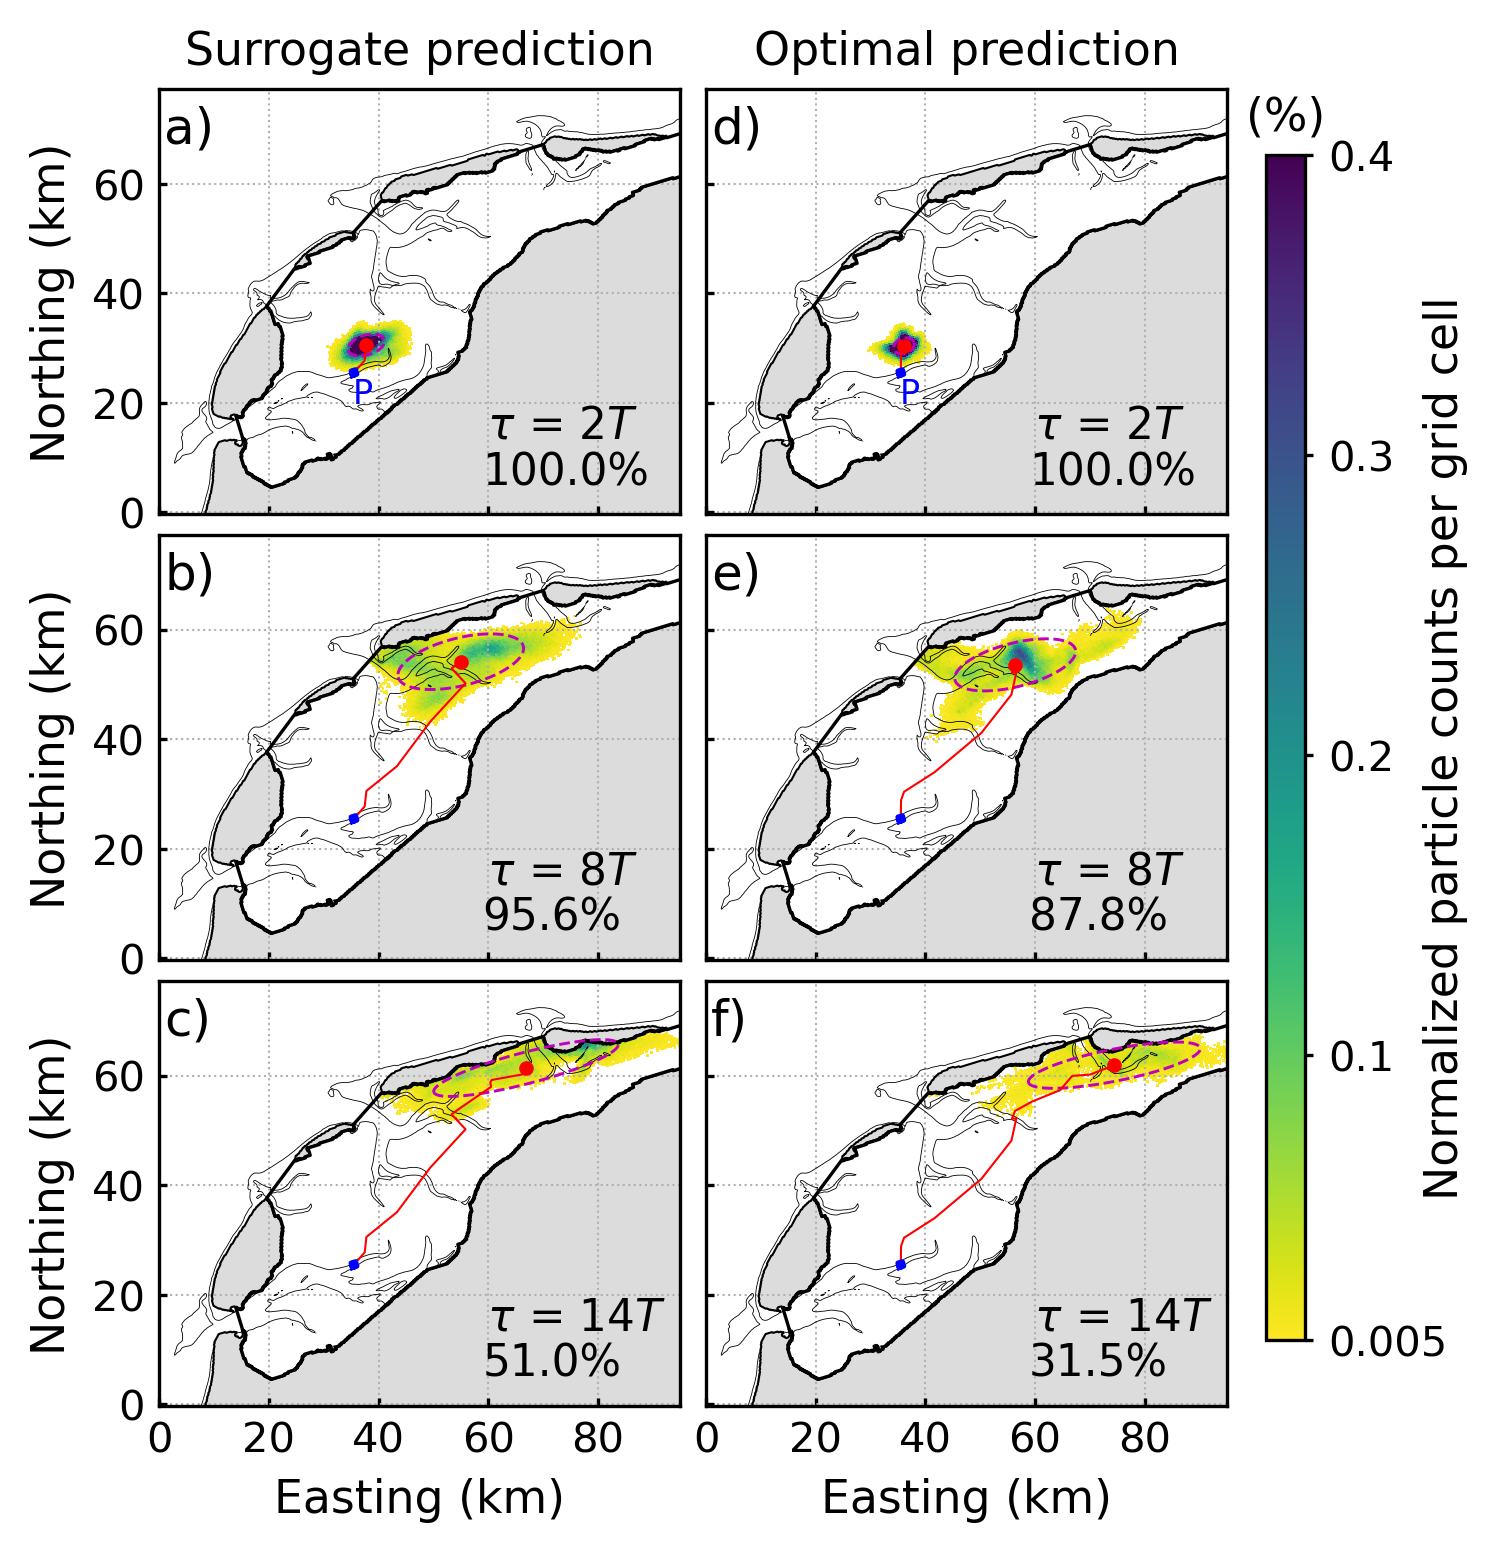

In [19]:
tt=[2,2,8,8,14,14]
lab0=['a)','d)','b)','e)','c)','f)']
#
fig,ax0=plt.subplots(3,2,figsize=(5.6,5.7),dpi=300, gridspec_kw={'wspace':0.05,'hspace':0.05})
axs=[]
for i in range(6):
    if i in [0,2,4]:
        dsst=dst_surrogate_pred; inout=ds_inoutp_surrogate_pred.inoutp; dss=ds_stats_surrogate_pred
        if i==0: 
            ax=ax0[0,0]
            xi=dsst.x.isel(obs=0).values; yi=dsst.y.isel(obs=0).values
            xxi=[xi[0],xi[-1],xi[-1],xi[0],xi[0]]; yyi=[yi[0],yi[0],yi[-1],yi[-1],yi[0]]
            _,_,xyip,_,_=transform_coordinates(dsto,np.array((xxi,yyi)).T*1.,xx,yy)
        if i==2: ax=ax0[1,0]
        if i==4: ax=ax0[2,0]
        lab1="Surrogate prediction"
    else:
        dsst=dst_optimal_pred; inout=ds_inoutp_optimal_pred.inoutp; dss=ds_stats_optimal_pred
        if i==1: ax=ax0[0,1]
        if i==3: ax=ax0[1,1]
        if i==5: ax=ax0[2,1]
        lab1="Optimal prediction"
    #background map---
    ax.pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=32,cmap=cmap_land,shading='auto',rasterized=True)
    ax.contour(xctp,yctp,mask,levels=[0],linewidths=.5,colors='k')
    ax.plot(bdr_dwsp[:,0],bdr_dwsp[:,1],ls='-',color='k',lw=.8,markersize=0)
    ax.contour(xctp,yctp,dsto.bathymetry,levels=[5],linewidths=.2,colors='k')
    #hist---
    varx=(dsst.x.isel(obs=tt[i])*inout.isel(obs=tt[i])).values
    vary=(dsst.y.isel(obs=tt[i])*inout.isel(obs=tt[i])).values
    hist,nn=binning_particles(varx,vary,xedges,yedges)
    val=(hist/npa_ini*100)
    per=np.round(np.nansum(val),1) #per of particles inside
    minval=0.005
    val[val<minval]=np.nan 
    aa=ax.pcolormesh(xgridp,ygridp,val,vmin=minval,vmax=0.4,cmap='viridis_r') 
    #cm---
    cmx,cmy=dss.cmx,dss.cmy
    _,_,xycmp,_,_=transform_coordinates(dsto,np.array((cmx,cmy)).T*1.,xx,yy)
    #dispersion elipse around cm---
    x0=xycmp[tt[i],0];y0=xycmp[tt[i],1]
    disp=np.array([[dss.dispxx[tt[i]],dss.dispxy[tt[i]]],
                 [dss.dispxy[tt[i]],dss.dispyy[tt[i]]]])/1e6
    eigval,eigvec=np.linalg.eig(disp)
    #order with first max eigenval
    ii=np.argsort(eigval)[::-1] 
    eigval=eigval[ii]**.5*np.sqrt(2); eigvec=eigvec[:,ii]
    #rotate the points 
    theta = np.arctan2(eigvec[1,0],eigvec[0,0]) #angle of max eigenvector with x-GETM-axis
    theta_dws=17*np.pi/180
    if theta<0: theta+=np.pi
    ang=np.arange(0,361,1)
    x = x0 + eigval[0]*np.cos(ang*np.pi/180)*np.cos(theta+theta_dws) - eigval[1]*np.sin(ang*np.pi/180)*np.sin(theta+theta_dws)
    y = y0 + eigval[0]*np.cos(ang*np.pi/180)*np.sin(theta+theta_dws) + eigval[1]*np.sin(ang*np.pi/180)*np.cos(theta+theta_dws)
    ax.plot(x,y,'--m',lw=0.7)
    #cm
    ax.plot(xycmp[np.arange(tt[i]+1),0],xycmp[np.arange(tt[i]+1),1],'-r',lw=.5)
    ax.plot(xycmp[np.arange(tt[i]+1),0][1:],xycmp[np.arange(tt[i]+1),1][1:],'-r',lw=0,ms=.7)
    ax.plot(xycmp[tt[i],0],xycmp[tt[i],1],'or',ms=2.5)
    ax.plot(xyip[:,0],xyip[:,1],'-b',lw=1.3)
    if i<2: ax.text(xyip[0,0],xyip[0,1]-5,'P',c='b',fontsize=8)
    #
    ax.grid(linewidth=0.5,ls=':')
    yticks=np.arange(540,640,20); ax.set_yticks(yticks)
    xticks=np.arange(100,240,20); ax.set_xticks(xticks);ax.set_xticklabels(xticks-100);
    ax.axis('equal'); 
    ax.axis([100,195,540,617]);
    ax.tick_params(direction="in")
    if i in [0,2,4]:
        ax.set_ylabel('Northing (km)');ax.set_yticklabels(yticks-540); ax.set_xticklabels("");
    if i in [1,3,5]: ax.set_xticklabels(""); ax.set_yticklabels("");
    if i>3: ax.set_xticklabels(xticks-100); ax.set_xlabel('Easting (km)');
    ax.text(.01,0.875,f"{lab0[i]}", transform=ax.transAxes, fontsize=glob_font_size+1)
    if i<2: ax.set_title(lab1)
    ax.text(.605,0.18,r" $\tau$" + f" = {tt[i]}$T$", transform=ax.transAxes, fontsize=glob_font_size-.5)        
    ax.text(.62,0.07,f"{per}%", transform=ax.transAxes, fontsize=glob_font_size-.5)
    axs+=[ax]
    if i==5:
        cticks=np.arange(0,0.5,0.1); cticks[0]=minval
        cticks_lab=[f"{i:.1f}" for i in cticks]; cticks_lab[0]=str(minval)
        cbar=fig.colorbar(aa,ax=axs,ticks=cticks,aspect=30,pad=0.03,shrink=.9); #cbar.ax.set_ylabel("(km)")
        cbar.ax.set_yticklabels(cticks_lab)
        cbar.ax.set_title(label="(%)");
        cbar.set_label("Normalized particle counts per grid cell", labelpad=-6);
print("time deployment: ",t_dep[it])
#
fig_name=f'spatial_concentration_particles_surrogate_and_optimal_predictions_{t_dep[it]}'
fig.savefig(f'{dir_main}{dir_repo}{dir_figures}{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)